In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from keras.src.layers import Dropout
from keras import Model, Input

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable, GeocoderInsufficientPrivileges
from math import radians, sin, cos, sqrt, atan2

In [40]:
# Load your data
df = pd.read_csv("jobs_in_data.csv")

# Split the 'salary_in_usd' column by 1000
df['salary_in_usd'] /= 1000

# Define features and target variable
X_numerical = df.select_dtypes(include=np.number).drop(
    columns=["salary_in_usd", "salary"])  # Select only numeric columns
y = df["salary_in_usd"]

# Scale numerical data
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Split data into train and test sets
X_train_num, X_test_num, y_train, y_test = train_test_split(X_numerical_scaled, y, test_size=0.2, random_state=42)

# Reshape the input data to include timestep dimension
X_train_reshaped = X_train_num.reshape(X_train_num.shape[0], X_train_num.shape[1], 1)
X_test_reshaped = X_test_num.reshape(X_test_num.shape[0], X_test_num.shape[1], 1)

# Define LSTM model
input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
lstm_layer = LSTM(128, return_sequences=True)(input_layer)
dropout_layer = Dropout(0.2)(lstm_layer)
lstm_layer2 = LSTM(64)(dropout_layer)
output_layer = Dense(1, activation='linear')(lstm_layer2)
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Evaluate the model
y_pred = model.predict(X_test_reshaped)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", np.sqrt(mse))


Epoch 1/100
211/211 [==============================] - 7s 11ms/step - loss: 23874.5039 - val_loss: 20139.7578
Epoch 2/100
211/211 [==============================] - 1s 5ms/step - loss: 18251.5410 - val_loss: 16831.9219
Epoch 3/100
211/211 [==============================] - 1s 7ms/step - loss: 15536.2236 - val_loss: 14495.8730
Epoch 4/100
211/211 [==============================] - 1s 7ms/step - loss: 13423.3789 - val_loss: 12579.5537
Epoch 5/100
211/211 [==============================] - 1s 6ms/step - loss: 11662.9463 - val_loss: 10970.6836
Epoch 6/100
211/211 [==============================] - 1s 6ms/step - loss: 10177.6260 - val_loss: 9605.9043
Epoch 7/100
211/211 [==============================] - 1s 6ms/step - loss: 8925.4336 - val_loss: 8458.3672
Epoch 8/100
211/211 [==============================] - 1s 7ms/step - loss: 7872.8203 - val_loss: 7498.6279
Epoch 9/100
211/211 [==============================] - 1s 6ms/step - loss: 6997.0576 - val_loss: 6705.0859
Epoch 10/100
211/211 [===

Mean Squared Error: 4084.3665521731436
Root Mean Squared Error: 63.909049063283234

['salary_in_usd'] / ['salary'] 


In [41]:
# Load your data
df = pd.read_csv("jobs_in_data.csv")

# Split the 'salary_in_usd' column by 1000
df['salary_in_usd'] /= 1000

# Calculate the ratio of "salary_in_usd" to "salary"
df['salary_ratio'] = df['salary_in_usd'] / df['salary']

# Define features and target variable
X_numerical = df.select_dtypes(include=np.number).drop(
    columns=["salary_in_usd", "salary"])  # Select only numeric columns
y = df["salary_in_usd"]

# Scale numerical data
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Split data into train and test sets
X_train_num, X_test_num, y_train, y_test = train_test_split(X_numerical_scaled, y, test_size=0.2, random_state=42)

# Reshape the input data to include timestep dimension
X_train_reshaped = X_train_num.reshape(X_train_num.shape[0], X_train_num.shape[1], 1)
X_test_reshaped = X_test_num.reshape(X_test_num.shape[0], X_test_num.shape[1], 1)

# Define LSTM model
input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
lstm_layer = LSTM(128, return_sequences=True)(input_layer)
dropout_layer = Dropout(0.2)(lstm_layer)
lstm_layer2 = LSTM(64)(dropout_layer)
output_layer = Dense(1, activation='linear')(lstm_layer2)
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Evaluate the model
y_pred = model.predict(X_test_reshaped)
mse = mean_squared_error(y_test, y_pred)
# print("MSE:", mse)
print("RMSE:", np.sqrt(mse))


Epoch 1/100
211/211 [==============================] - 50s 16ms/step - loss: 22391.4121 - val_loss: 19288.1348
Epoch 2/100
211/211 [==============================] - 2s 9ms/step - loss: 17403.2539 - val_loss: 15874.2588
Epoch 3/100
211/211 [==============================] - 3s 12ms/step - loss: 14443.8457 - val_loss: 13284.2080
Epoch 4/100
211/211 [==============================] - 2s 10ms/step - loss: 12113.7109 - val_loss: 11194.1738
Epoch 5/100
211/211 [==============================] - 2s 10ms/step - loss: 10228.8760 - val_loss: 9501.7842
Epoch 6/100
211/211 [==============================] - 2s 11ms/step - loss: 8701.6094 - val_loss: 8132.6328
Epoch 7/100
211/211 [==============================] - 3s 13ms/step - loss: 7477.5791 - val_loss: 7046.3184
Epoch 8/100
211/211 [==============================] - 2s 11ms/step - loss: 6509.3374 - val_loss: 6192.1763
Epoch 9/100
211/211 [==============================] - 3s 12ms/step - loss: 5760.6543 - val_loss: 5541.4150
Epoch 10/100
211/21

['salary_in_usd'] / ['salary'] 
RMSE: 60.78381977426994

experience_mapping for ['experience_level']

In [42]:
# Load your data
df = pd.read_csv("jobs_in_data.csv")

# Split the 'salary_in_usd' column by 1000
df['salary_in_usd'] /= 1000

# Calculate the ratio of "salary_in_usd" to "salary"
df['salary_ratio'] = df['salary_in_usd'] / df['salary']

experience_mapping = {
    'Entry-level': 1,
    'Mid-level': 2,
    'Senior': 3,
    'Executive': 4
}

# Map experience levels to ordinal numbers
df['experience_level_encoded'] = df['experience_level'].map(experience_mapping)

# Define features and target variable
X_numerical = df.select_dtypes(include=np.number).drop(
    columns=["salary_in_usd", "salary"])  # Select only numeric columns
y = df["salary_in_usd"]

# Scale numerical data
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Split data into train and test sets
X_train_num, X_test_num, y_train, y_test = train_test_split(X_numerical_scaled, y, test_size=0.2, random_state=42)

# Reshape the input data to include timestep dimension
X_train_reshaped = X_train_num.reshape(X_train_num.shape[0], X_train_num.shape[1], 1)
X_test_reshaped = X_test_num.reshape(X_test_num.shape[0], X_test_num.shape[1], 1)

# Define LSTM model
input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
lstm_layer = LSTM(128, return_sequences=True)(input_layer)
dropout_layer = Dropout(0.2)(lstm_layer)
lstm_layer2 = LSTM(64)(dropout_layer)
output_layer = Dense(1, activation='linear')(lstm_layer2)
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Evaluate the model
y_pred = model.predict(X_test_reshaped)
mse = mean_squared_error(y_test, y_pred)
# print("MSE:", mse)
print("RMSE:", np.sqrt(mse))


Epoch 1/100
211/211 [==============================] - 10s 19ms/step - loss: 21996.9043 - val_loss: 19304.7539
Epoch 2/100
211/211 [==============================] - 3s 14ms/step - loss: 17552.1191 - val_loss: 16081.4072
Epoch 3/100
211/211 [==============================] - 2s 11ms/step - loss: 14645.5410 - val_loss: 13461.4102
Epoch 4/100
211/211 [==============================] - 3s 12ms/step - loss: 12270.4336 - val_loss: 11323.5312
Epoch 5/100
211/211 [==============================] - 3s 12ms/step - loss: 10334.7119 - val_loss: 9585.7695
Epoch 6/100
211/211 [==============================] - 3s 13ms/step - loss: 8767.9404 - val_loss: 8183.9673
Epoch 7/100
211/211 [==============================] - 3s 12ms/step - loss: 7513.6885 - val_loss: 7070.1533
Epoch 8/100
211/211 [==============================] - 2s 12ms/step - loss: 6524.6396 - val_loss: 6198.6958
Epoch 9/100
211/211 [==============================] - 2s 10ms/step - loss: 5759.7139 - val_loss: 5535.7949
Epoch 10/100
211/2

experience_mapping for ['experience_level']
RMSE: 57.54844132269867

distance from  ["employee_residence"] - ["company_location"] 

In [43]:
location_coordinates = {'Germany': (51.1638175, 10.4478313), 'United States': (39.7837304, -100.445882),
                        'United Kingdom': (54.7023545, -3.2765753), 'Canada': (61.0666922, -107.991707),
                        'Spain': (39.3260685, -4.8379791), 'Ireland': (52.865196, -7.9794599),
                        'South Africa': (-28.8166236, 24.991639), 'Poland': (52.215933, 19.134422),
                        'France': (46.603354, 1.8883335), 'Netherlands': (52.2434979, 5.6343227),
                        'Luxembourg': (49.6112768, 6.129799), 'Lithuania': (55.3500003, 23.7499997),
                        'Portugal': (39.6621648, -8.1353519), 'Gibraltar': (36.1285933, -5.3474761),
                        'Australia': (-24.7761086, 134.755), 'Colombia': (4.099917, -72.9088133),
                        'Ukraine': (49.4871968, 31.2718321), 'Slovenia': (46.1199444, 14.8153333),
                        'Romania': (45.9852129, 24.6859225), 'Greece': (43.2097838, -77.6930602),
                        'India': (22.3511148, 78.6677428), 'Latvia': (56.8406494, 24.7537645),
                        'Mauritius': (-20.2759451, 57.5703566), 'Russia': (64.6863136, 97.7453061),
                        'Italy': (42.6384261, 12.674297), 'South Korea': (36.638392, 127.6961188),
                        'Estonia': (58.7523778, 25.3319078), 'Czech Republic': (49.7439047, 15.3381061),
                        'Brazil': (-10.3333333, -53.2), 'Qatar': (25.3336984, 51.2295295),
                        'Kenya': (1.4419683, 38.4313975), 'Denmark': (55.670249, 10.3333283),
                        'Ghana': (8.0300284, -1.0800271), 'Sweden': (59.6749712, 14.5208584),
                        'Turkey': (38.9597594, 34.9249653), 'Switzerland': (46.7985624, 8.2319736),
                        'Andorra': (42.5407167, 1.5732033), 'Ecuador': (-1.3397668, -79.3666965),
                        'Mexico': (19.4326296, -99.1331785), 'Israel': (30.8124247, 34.8594762),
                        'Nigeria': (9.6000359, 7.9999721), 'Saudi Arabia': (25.6242618, 42.3528328),
                        'Argentina': (-34.9964963, -64.9672817), 'Japan': (36.5748441, 139.2394179),
                        'Central African Republic': (7.0323598, 19.9981227), 'Finland': (63.2467777, 25.9209164),
                        'Singapore': (1.357107, 103.8194992), 'Croatia': (45.3658443, 15.6575209),
                        'Armenia': (4.491976149999999, -75.74135085294314),
                        'Bosnia and Herzegovina': (44.3053476, 17.5961467), 'Pakistan': (30.3308401, 71.247499),
                        'Iran': (32.6475314, 54.5643516), 'Bahamas': (24.7736546, -78.0000547),
                        'Austria': (47.59397, 14.12456), 'Puerto Rico': (18.2247706, -66.4858295),
                        'American Samoa': (-14.297124, -170.7131481), 'Thailand': (13.03876215, 101.70017611907599),
                        'Philippines': (12.7503486, 122.7312101), 'Belgium': (50.6402809, 4.6667145),
                        'Egypt': (26.2540493, 29.2675469), 'Indonesia': (-2.4833826, 117.8902853),
                        'United Arab Emirates': (24.0002488, 53.9994829), 'Malaysia': (4.5693754, 102.2656823),
                        'Honduras': (15.2572432, -86.0755145), 'Algeria': (28.0000272, 2.9999825),
                        'Iraq': (33.0955793, 44.1749775), 'China': (35.000074, 104.999927),
                        'New Zealand': (-41.5000831, 172.8344077), 'Moldova': (47.2879608, 28.5670941),
                        'Malta': (35.8885993, 14.4476911), 'Uganda': (1.5333554, 32.2166578),
                        'Tunisia': (36.8002068, 10.1857757), 'Peru': (-6.8699697, -75.0458515),
                        'Uzbekistan': (41.32373, 63.9528098), 'Georgia': (32.3293809, -83.1137366),
                        'Kuwait': (29.3796532, 47.9734174), 'Cyprus': (34.9174159, 32.889902651331866),
                        'Costa Rica': (10.2735633, -84.0739102), 'Chile': (-31.7613365, -71.3187697),
                        'Bolivia': (-17.0568696, -64.9912286), 'Dominican Republic': (19.0974031, -70.3028026),
                        'Vietnam': (15.9266657, 107.9650855), 'Bulgaria': (42.6073975, 25.4856617),
                        'Jersey': (49.2214561, -2.1358386), 'Serbia': (44.024322850000004, 21.07657433209902),
                        'Hong Kong': (22.350627, 114.1849161)}

# Haversine function
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371 * c  # Radius of the Earth in kilometers

    return distance

df = pd.read_csv("jobs_in_data.csv")

# Calculate distances and add them to the DataFrame
df['distance_company_to_residence'] = df.apply(lambda row: haversine(*location_coordinates[row['company_location']], *location_coordinates[row['employee_residence']]), axis=1)

# Load your data

# Split the 'salary_in_usd' column by 1000
df['salary_in_usd'] /= 1000

# Calculate the ratio of "salary_in_usd" to "salary"
df['salary_ratio'] = df['salary_in_usd'] / df['salary']

experience_mapping = {
    'Entry-level': 1,
    'Mid-level': 2,
    'Senior': 3,
    'Executive': 4
}

# Map experience levels to ordinal numbers
df['experience_level_encoded'] = df['experience_level'].map(experience_mapping)


# Calculate the percentile rank of each salary within its job category
df['Percentile'] = df.groupby('job_category')['salary'].rank(pct=True)

# Normalize the percentile ranks to a scale of 0 to 1
min_percentile = df['Percentile'].min()
max_percentile = df['Percentile'].max()
df['Normalized_Salary_within_Job_Category'] = (df['Percentile'] - min_percentile) / (max_percentile - min_percentile)

# Drop the temporary 'Percentile' column if you don't need it anymore
df.drop(columns=['Percentile'], inplace=True)

# Define features and target variable
X_numerical = df.select_dtypes(include=np.number).drop(
    columns=["salary_in_usd", "salary"])  # Select only numeric columns
y = df["salary_in_usd"]

# Scale numerical data
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Split data into train and test sets
X_train_num, X_test_num, y_train, y_test = train_test_split(X_numerical_scaled, y, test_size=0.2, random_state=42)

# Reshape the input data to include timestep dimension
X_train_reshaped = X_train_num.reshape(X_train_num.shape[0], X_train_num.shape[1], 1)
X_test_reshaped = X_test_num.reshape(X_test_num.shape[0], X_test_num.shape[1], 1)

# Define LSTM model
input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
lstm_layer = LSTM(128, return_sequences=True)(input_layer)
dropout_layer = Dropout(0.2)(lstm_layer)
lstm_layer2 = LSTM(64)(dropout_layer)
output_layer = Dense(1, activation='linear')(lstm_layer2)
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Evaluate the model
y_pred = model.predict(X_test_reshaped)
mse = mean_squared_error(y_test, y_pred)
# print("MSE:", mse)
print("RMSE:", np.sqrt(mse))





Epoch 1/100
211/211 [==============================] - 10s 19ms/step - loss: 21812.9199 - val_loss: 19512.8633
Epoch 2/100
211/211 [==============================] - 3s 13ms/step - loss: 17793.7441 - val_loss: 16336.7334
Epoch 3/100
211/211 [==============================] - 2s 12ms/step - loss: 14902.7871 - val_loss: 13727.7686
Epoch 4/100
211/211 [==============================] - 3s 13ms/step - loss: 12531.8887 - val_loss: 11579.5352
Epoch 5/100
211/211 [==============================] - 3s 13ms/step - loss: 10582.1504 - val_loss: 9820.7744
Epoch 6/100
211/211 [==============================] - 3s 16ms/step - loss: 8988.8584 - val_loss: 8384.9834
Epoch 7/100
211/211 [==============================] - 3s 15ms/step - loss: 7700.0137 - val_loss: 7240.5928
Epoch 8/100
211/211 [==============================] - 3s 12ms/step - loss: 6676.1836 - val_loss: 6335.2036
Epoch 9/100
211/211 [==============================] - 3s 13ms/step - loss: 5881.8696 - val_loss: 5644.6968
Epoch 10/100
211/2

Normalized Salary within Job Category
RMSE: 25.531453514062534

59/59 [==============================] - 0s 5ms/step


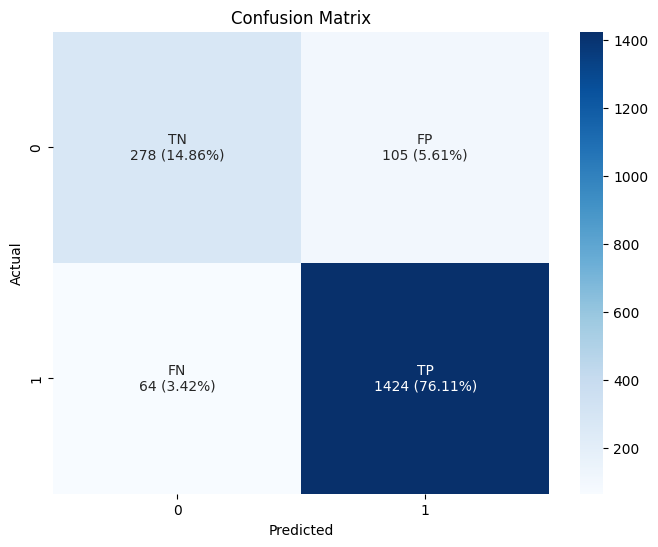

Accuracy: 0.9096739711384286
Precision: 0.9313276651406148
Recall: 0.956989247311828
RMSE: 27.08132748785223


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import numpy as np

# Make predictions on the scaled test set
predictions_scaled = model.predict(X_test_reshaped)

# Convert predictions back to original scale
predictions = predictions_scaled.flatten()

# Define thresholds for classification
threshold_positive = 100  # Define a suitable threshold based on your problem

# Classify predictions into two categories based on the threshold
y_test_class = (y_test >= threshold_positive)
predictions_class = (predictions >= threshold_positive)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_class, predictions_class)

# Calculate percentages
total = np.sum(conf_matrix)
percentages = (conf_matrix / total) * 100

# Define labels for each cell with amount, percentage, and the type of classification
labels = np.empty_like(conf_matrix, dtype=object)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        if i == 0 and j == 0:  # True Negative
            labels[i, j] = f"TN\n{conf_matrix[i, j]} ({percentages[i, j]:.2f}%)"
        elif i == 0 and j == 1:  # False Positive
            labels[i, j] = f"FP\n{conf_matrix[i, j]} ({percentages[i, j]:.2f}%)"
        elif i == 1 and j == 0:  # False Negative
            labels[i, j] = f"FN\n{conf_matrix[i, j]} ({percentages[i, j]:.2f}%)"
        else:  # True Positive
            labels[i, j] = f"TP\n{conf_matrix[i, j]} ({percentages[i, j]:.2f}%)"

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print accuracy, precision, and recall
accuracy = accuracy_score(y_test_class, predictions_class)
precision = precision_score(y_test_class, predictions_class)
recall = recall_score(y_test_class, predictions_class)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Calculate and print RMSE
mse = mean_squared_error(y_test, predictions)
print("RMSE:", np.sqrt(mse))
